# 5. Faster R-CNN

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


## 5.1 Dataset


In [ ]:
# !git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
# !python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
# !unzip -q Face\ Mask\ Detection.zip
#!unzip -q brain.zip
from google.colab import drive
import shutil
import os
drive.mount('/content/drive')
# source_folder = '/content/drive/MyDrive/datasets'
# destination_folder = '/content/'

# # Mendapatkan nama folder terakhir dari jalur sumber
# folder_name = source_folder.split('/')[-1]

# # Menggabungkan jalur tujuan dengan nama folder terakhir
# destination_folder = os.path.join(destination_folder, folder_name)

# shutil.copytree(source_folder, destination_folder)


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/datasets

/content/drive/MyDrive/datasets


## 5.2 Split Data


In [ ]:
import os
import random
import numpy as np
import shutil

# print(len(os.listdir('annotations')))
# print(len(os.listdir('images')))

# !mkdir test_images
# !mkdir test_annotations


# random.seed(1234)
# idx = random.sample(range(810), 810)

# for img in np.array(sorted(os.listdir('images')))[idx]:
#     shutil.move('images/'+img, 'test_images/'+img)

# for annot in np.array(sorted(os.listdir('annotations')))[idx]:
#     shutil.move('annotations/'+annot, 'test_annotations/'+annot)

# print(len(os.listdir('annotations')))
# print(len(os.listdir('images')))
# print(len(os.listdir('test_annotations')))
# print(len(os.listdir('test_images')))

Kami juga akan mengimpor paket yang diperlukan untuk pemodelan. `torchvision` digunakan untuk pemrosesan gambar dan memiliki paket bawaan untuk kumpulan data dan paket untuk model.

In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

## 5.3 Definisi Kelas

In [ ]:
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

adjust_label = 0

def generate_label(obj):

    if obj.find('name').text == "Brain-Hemorrhage":

        return 1 + adjust_label

    return 0 + adjust_label

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

Dataset akan dimuat menggunakan fungsi `torch.utils.data.DataLoader` dengan menentukan ukuran batch 4. Ukuran batch dapat diatur secara bebas sesuai dengan ukuran memori individu.

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)

In [ ]:
print(len(data_loader))
print(len(test_data_loader))

135
48


## 5.4 Load Model

`torchvision.models.detection` menyediakan API R-CNN yang Lebih Cepat (`torchvision.models.detection.fasterrcnn_resnet50_fpn`) untuk implementasi yang mudah. Ini memberikan model yang telah dilatih sebelumnya dengan ResNet50 pada set data COCO, dan dapat disetel ke `pretrained=True/False`.

Setelah itu, saat memuat model, tetapkan jumlah kelas yang diinginkan di `num_classes` dan gunakan model tersebut. Perhatikan bahwa saat menggunakan Faster R-CNN, nomor yang menyertakan kelas latar belakang harus ditentukan dalam `num_classes`. Dengan kata lain, Anda perlu menambahkan kelas latar belakang dengan menambah satu per satu jumlah kelas dalam kumpulan data aktual.

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## 5.5 Training

Jika GPU tersedia, model yang dimuat dikirim ke GPU dengan menetapkannya sebagai perangkat.

In [ ]:
model = get_model_instance_segmentation(2)
rpn = model.rpn
print("RPN Anchor Ratios:", rpn.anchor_generator.aspect_ratios)
print("RPN Anchor Scales:", rpn.anchor_generator.sizes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 88.6MB/s]


RPN Anchor Ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
RPN Anchor Scales: ((32,), (64,), (128,), (256,), (512,))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Dari output di atas, Anda dapat melihat terdiri dari lapisan apa Fastser R-CNN. Saat ini, Anda dapat memeriksa apakah GPU tersedia melalui `torch.cuda.is_available()`.

In [ ]:
torch.cuda.is_available()

True

Sekarang modelnya sudah dibuat, mari kita latih. Mari atur jumlah pelatihan (`num_epochs`) menjadi `x int` dan optimalkan melalui metode SGD. Setiap hyperparameter dapat dimodifikasi dan digunakan secara bebas.

In [ ]:
num_epochs = 100
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)

Sekarang mari belajar. Dalam data_loader yang dibuat di atas, batch digunakan dalam model secara berurutan, lalu pengoptimalan dilakukan melalui perhitungan loss. Anda dapat memeriksa progres pembelajaran melalui loss output di setiap epoch.

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        # i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : nan, time : 188.4490830898285
epoch : 2, Loss : nan, time : 7.5799665451049805
epoch : 3, Loss : nan, time : 7.600790023803711
epoch : 4, Loss : nan, time : 7.5868096351623535
epoch : 5, Loss : nan, time : 7.580601930618286
epoch : 6, Loss : nan, time : 7.60663104057312
epoch : 7, Loss : nan, time : 7.623838901519775
epoch : 8, Loss : nan, time : 7.753695487976074
epoch : 9, Loss : nan, time : 7.650017499923706
epoch : 10, Loss : nan, time : 7.5719709396362305
epoch : 11, Loss : nan, time : 7.626389980316162
epoch : 12, Loss : nan, time : 7.596876382827759
epoch : 13, Loss : nan, time : 7.587152719497681
epoch : 14, Loss : nan, time : 7.587102651596069
epoch : 15, Loss : nan, time : 7.6076507568359375
epoch : 16, Loss : nan, time : 7.602969408035278
epoch : 17, Loss : nan, time : 7.726934432983398
epoch : 18, Loss : nan, time : 7.546762228012085
epoch : 19, Loss : nan, time : 7.606069803237915
epoch : 20, Los

학습시킨 가중치를 저장하고 싶다면, `torch.save`를 이용하여 저장해두고 나중에 언제든지 불러와 사용할 수 있습니다.

In [ ]:
hp = "_0.001_4_ResNet50"

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}{hp}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}{hp}.pt'))

<All keys matched successfully>

## 5.6 Prediksi



Setelah pelatihan model selesai, mari kita periksa hasil prediksi untuk melihat apakah sudah dilatih dengan baik. Hasil prediksi meliputi koordinat kotak pembatas (box), kelas (label), dan skor (skor). Nilai kepercayaan kelas disimpan dalam skor, dan kami akan menentukan fungsi `make_prediction` untuk mengekstrak hanya yang memiliki ambang batas 0,5 atau lebih tinggi. Dan saya hanya mencetak hasil untuk test_data_loader batch pertama.

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    print(len(test_data_loader))
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        break

48


Mari menggambar kotak pembatas pada gambar menggunakan hasil prediksi. Keluarkan gambar dengan fungsi `plot_image_from_output` yang ditentukan di atas. Target adalah lokasi kotak pembatas yang sebenarnya dan Prediksi adalah hasil prediksi dari model. Anda dapat melihat bahwa model menemukan lokasi kotak pembatas yang sebenarnya dengan baik.

({'boxes': tensor([[210., 142., 306., 170.]]), 'labels': tensor([1])},)
Target :  tensor([1])


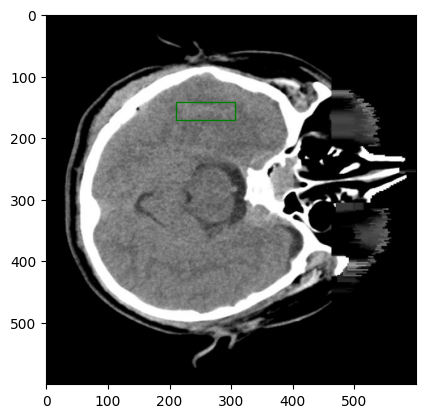

Prediction :  tensor([], device='cuda:0', dtype=torch.int64)
{'boxes': tensor([[210., 142., 306., 170.]]), 'labels': tensor([1])}
{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}


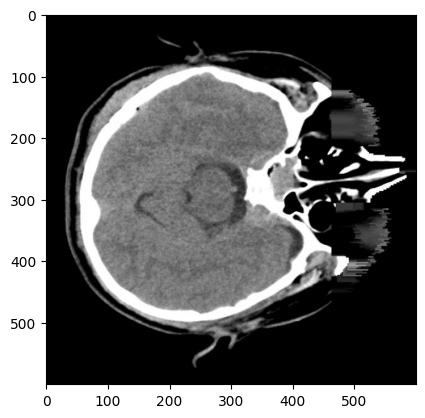

IoU: tensor([], size=(0, 1))


In [ ]:
from torchvision.ops import box_iou
print(annotations)
_idx = 0
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
print(annotations[_idx])
print(pred[_idx])

# Create a tensor on the CUDA device
for key in pred[_idx]:
    pred[_idx][key] = pred[_idx][key].cpu()

plot_image_from_output(imgs[_idx], pred[_idx])
iou = box_iou(pred[_idx]['boxes'],annotations[_idx]['boxes'])
print("IoU:", iou)

Sekarang, mari kita evaluasi hasil prediksi pada seluruh data uji. Pertama, tempatkan hasil prediksi dan label sebenarnya untuk semua data pengujian ke dalam `preds_adj_all` dan `annot_all`, masing-masing.

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.7)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 48/48 [00:02<00:00, 20.95it/s]


Dan hitung nilai mAP melalui file utils_ObjectDetection.py di folder Tutorial-Book-Utils. Fungsi `get_batch_statistics` menghitung nilai statistik antara kotak pembatas yang memenuhi kondisi IoU (Intersection of Union), dan fungsi `ap_per_class` menghitung nilai AP untuk setiap kelas.

In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/drive/MyDrive/datasets/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # batch semua disatukan
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.5816390660596014
AP : tensor([0.5816], dtype=torch.float64)


In [ ]:
%cd ..

In [ ]:
%pwd